In this notebook, we search for ground states of the Transverse Field Ising (TFI) model on a finite square lattice using imaginary time TEBD algorithm. We start by showing that increasing the bond dimension yields a lower ground state energy. We then compute imaginary time TEBD for different time steps $\Delta\tau$, observing that there exists an optimal choice for the time step.

# Ground state search for different values of $D_\text{max}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("../../")
from src.isoTPS.square import isoTPS
from src.models import tfi
from src.utility import utility

In [3]:
# Parameters for the isoTPS
tps_parameters = {
    # Dimensions of the lattice
    "Lx": 4,
    "Ly": 4,
    # Maximum bond dimension
    "D_max": 2,
    "chi_factor": 4,
    # Physical bond dimension
    "d": 2,
    # Options for the YB move
    "yb_options" : { 
        "mode" : "svd",
        "disentangle": True,
        "disentangle_options": {
            "mode": "renyi_approx",
            "renyi_alpha": 0.5,
            "method": "trm",
            "N_iters": 100,
        }
    },
    # Options for the TEBD algorithm
    "tebd_options": {
        "mode" : "iterate_polar",
        "N_iters": 100,
    },
    # Options for variational column optimization
    "perform_variational_column_optimization": False,
    "variational_column_optimization_options": {},
    # debug logging
    "debug_logger_options": {}
}
# TFI field and interaction strength
g = 3.5
J = 1.0
# time step for the TEBD algorithm
dt = 0.1
# number of iterations for the TEBD algorithm
N_iters_tebd = 10
# Maximum bond dimensions
D_maxs = [2, 3, 4]

In [4]:
# Create the Hamiltonian as a list of local bond operators
tfi_model = tfi.TFI(g=g, J=J)
H_bonds = tfi_model.compute_H_bonds_2D_Square(Lx=tps_parameters["Ly"], Ly=tps_parameters["Ly"])
# Compute U = e^{-dt*H}. We use 2nd order TEBD, therefore dt/2 is used as time step
U_bonds = utility.calc_U_bonds(H_bonds, dt/2)

In [14]:
Es = []
for D_max in D_maxs:
    print(f"Performing ground state search for D_max = {D_max}.")
    start = time.time()
    # Set maximum bond dimension
    tps_parameters["D_max"] = D_max
    # Create an isoTPS with a spin-1/2 at each site and initialize it in the "all up" state.
    tps = isoTPS.isoTPS_Square(**tps_parameters)
    tps.initialize_spinup()
    # Keep track of energy
    Es.append([np.sum(tps.copy().compute_expectation_values_twosite(H_bonds))])
    # Perform TEBD
    for n in range(N_iters_tebd):
        print(f"Computing TEBD step {n}...")
        tps.perform_TEBD2(U_bonds, 1)
        Es[-1].append(np.sum(tps.copy().compute_expectation_values_twosite(H_bonds)))
    end = time.time()
    print(f"Took {round(end-start, 3)} seconds.")

Performing ground state search for D_max = 2.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 71.801 seconds.
Performing ground state search for D_max = 3.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 312.489 seconds.
Performing ground state search for D_max = 4.
Computing TEBD step 0...
Computing TEBD step 1...
Computing TEBD step 2...
Computing TEBD step 3...
Computing TEBD step 4...
Computing TEBD step 5...
Computing TEBD step 6...
Computing TEBD step 7...
Computing TEBD step 8...
Computing TEBD step 9...
Took 1059.905 seconds.


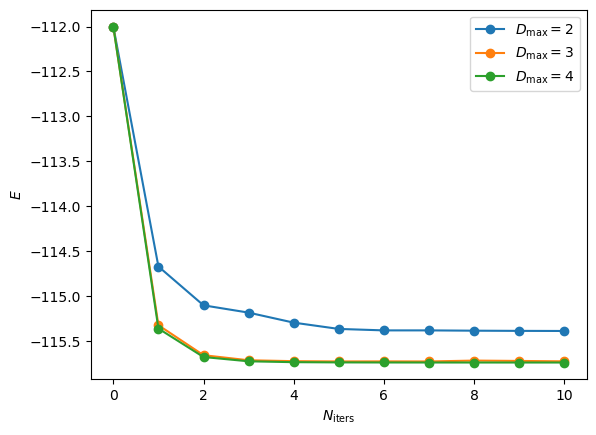

In [17]:
for i, D_max in enumerate(D_maxs):
    plt.plot(np.real_if_close(Es[i]), "o-", label=r"$D_\text{max} = "+str(D_max)+r"$")
plt.legend()
plt.xlabel(r"$N_\text{iters}$")
plt.ylabel(r"$E$")
plt.show()

# Finding the optimal time step $\Delta\tau$

In [ ]:
import h5py
from src.runs import gs_energy_vs_dtau_TEBD

In [6]:
dtaus = np.logspace(np.log10(0.5), np.log10(0.01), 11)
print(dtaus)

[0.5        0.33812167 0.22865253 0.15462475 0.10456396 0.07071068
 0.04781762 0.03233635 0.02186724 0.01478758 0.01      ]


In [7]:
run_parameters = {
    "tps_params": {
        # Dimensions of the lattice
        "Lx": 4,
        "Ly": 4,
        # Maximum bond dimension
        "D_max": 2,
        "chi_factor": 4,
        # Physical bond dimension
        "d": 2,
        # Options for the YB move
        "yb_options" : { 
            "mode" : "svd",
            "disentangle": True,
            "disentangle_options": {
                "mode": "renyi_approx",
                "renyi_alpha": 0.5,
                "method": "trm",
                "N_iters": 100,
            }
        },
        # Options for the TEBD algorithm
        "tebd_options": {
            "mode" : "iterate_polar",
            "N_iters": 100,
        },
        # Options for variational column optimization
        "perform_variational_column_optimization": False,
        "variational_column_optimization_options": {},
        # debug logging
        "debug_logger_options": {
            "log_algorithm_walltimes": True,
            "log_approximate_column_error_yb": True,
            "log_approximate_column_error_tebd": True,
        }
    },
    "model_params": {
        "g": 3.5,
        "J": 1.0
    },
    "dtaus": dtaus,
    # number of TEBD iterations per dtau
    "N_steps": 10
}

In [9]:
for i, dtau in enumerate(dtaus):
    print(f"Computing data point for dtau = {dtau}...")
    run_parameters["dtau_index"] = i
    run_parameters["output_filename"] = f"output/gs_energy_vs_dtau/result_D_{run_parameters["tps_params"]["D_max"]}_dtau_{dtau}"
    gs_energy_vs_dtau_TEBD.perform_gs_energy_vs_dtau_run(**run_parameters)

Computing data point for dtau = 0.5...
Computing data point for dtau = 0.33812166890312073...
Computing data point for dtau = 0.22865252596366317...
Computing data point for dtau = 0.15462474735549586...
Computing data point for dtau = 0.10456395525912734...
Computing data point for dtau = 0.07071067811865475...
Computing data point for dtau = 0.04781762498950186...
Computing data point for dtau = 0.03233635032886786...
Computing data point for dtau = 0.021867241478865564...
Computing data point for dtau = 0.014787576366283143...
Computing data point for dtau = 0.01...


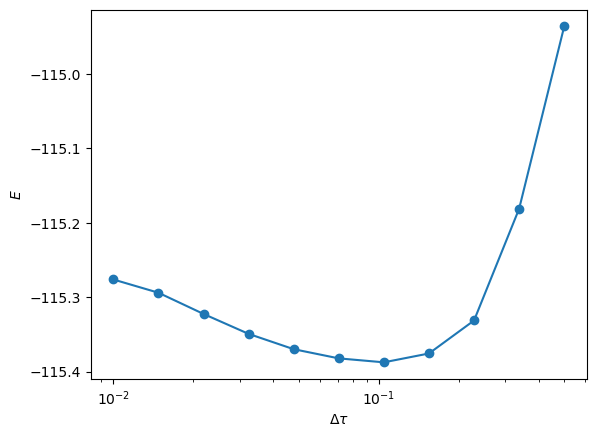

In [19]:
Es = []
for i, dtau in enumerate(dtaus):
    with h5py.File(f"output/gs_energy_vs_dtau/result_D_{run_parameters["tps_params"]["D_max"]}_dtau_{dtau}.h5") as file:
        Es.append(file["energies"][()][-1])

plt.plot(dtaus, np.real_if_close(Es), "o-")
plt.xscale("log")
plt.ylabel(r"$E$")
plt.xlabel(r"$\Delta\tau$")
plt.show()